In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc
from joblib import load, dump
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results


from tqdm import tqdm

tqdm.pandas(ascii=True)

In [2]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1)
    return X

In [3]:
flist = glob('../data/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)

In [28]:
dfx = df[df.columns[:-1]]
dfy = df[df.columns[-1:]]
dfx = np.log2(dfx + 1) #apply log2(x + 1)

In [18]:
data_save_folder = '/raid/shenwanxiang/transcriptome/pan-cancer'
X1_ns = load(os.path.join(data_save_folder, 'Agg1_noisys.data')) 
mp = loadmap('/raid/shenwanxiang/agg_mp_object/pan-cancer.mp')

In [8]:
len(X1_ns)

7

In [16]:
n, w, h, c = X1_ns[0].shape

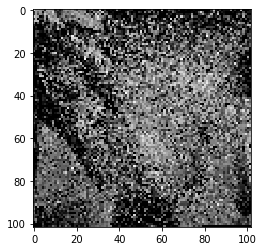

In [17]:
plt.imshow(X1_ns[0][0].reshape(w,h), cmap='gray')

In [85]:
new_X1_ns = []
for X in X1_ns:
    X1 = X.copy()
    df1 = pd.DataFrame(X1.reshape(n, w*h), columns=mp.df_grid.sort_values(['y','x'])['v'].to_list())
    df11 = df1[dfx.columns]
    df1 = df11.join(pd.DataFrame(np.zeros(shape = (n,w*h - df11.shape[-1]))))
    X1 = df1.values.reshape(n,w,h,1)    
    new_X1_ns.append(X1)

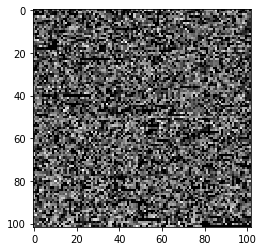

In [86]:
plt.imshow(new_X1_ns[0][0].reshape(w,h), cmap='gray')

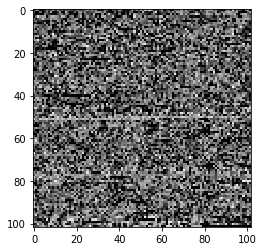

In [101]:
plt.imshow(new_X1_ns[0][10].reshape(w,h), cmap='gray')

In [87]:
dump(new_X1_ns, os.path.join(data_save_folder, 'RP1_noisys.data')) 

['/raid/shenwanxiang/transcriptome/pan-cancer/RP1_noisys.data']

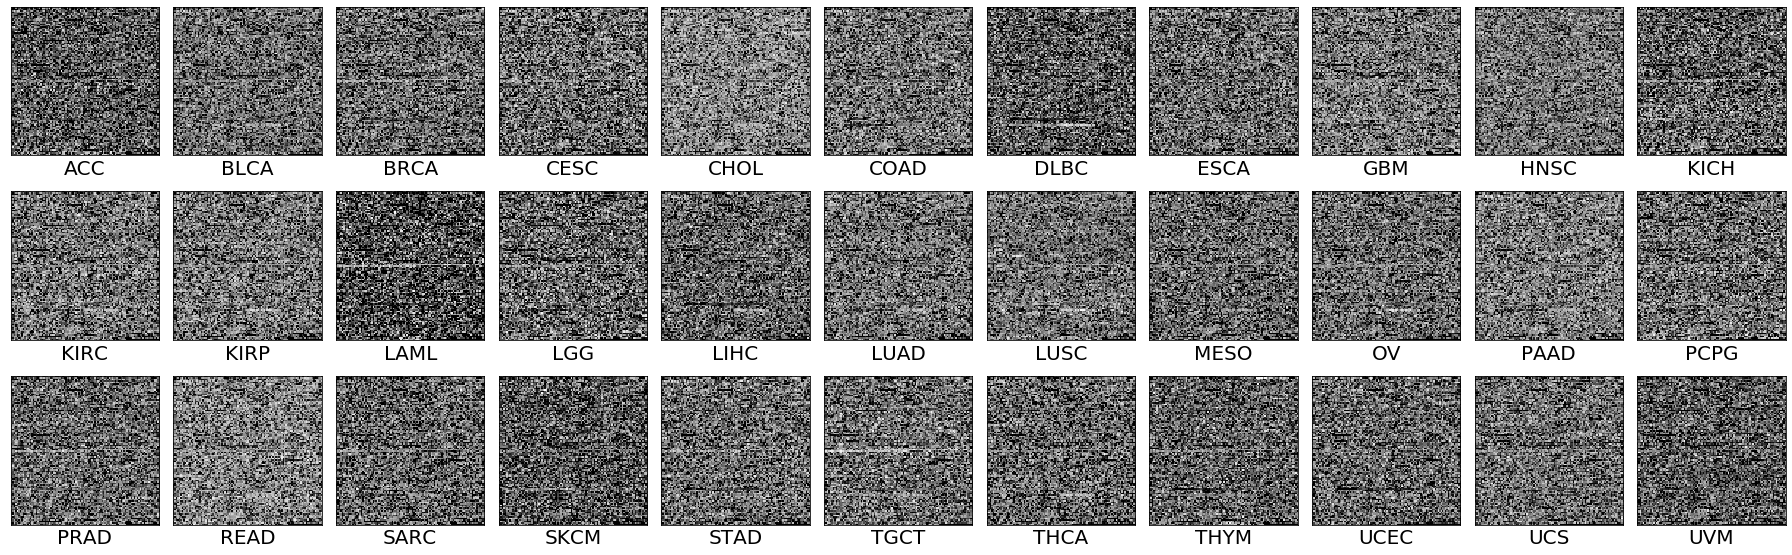

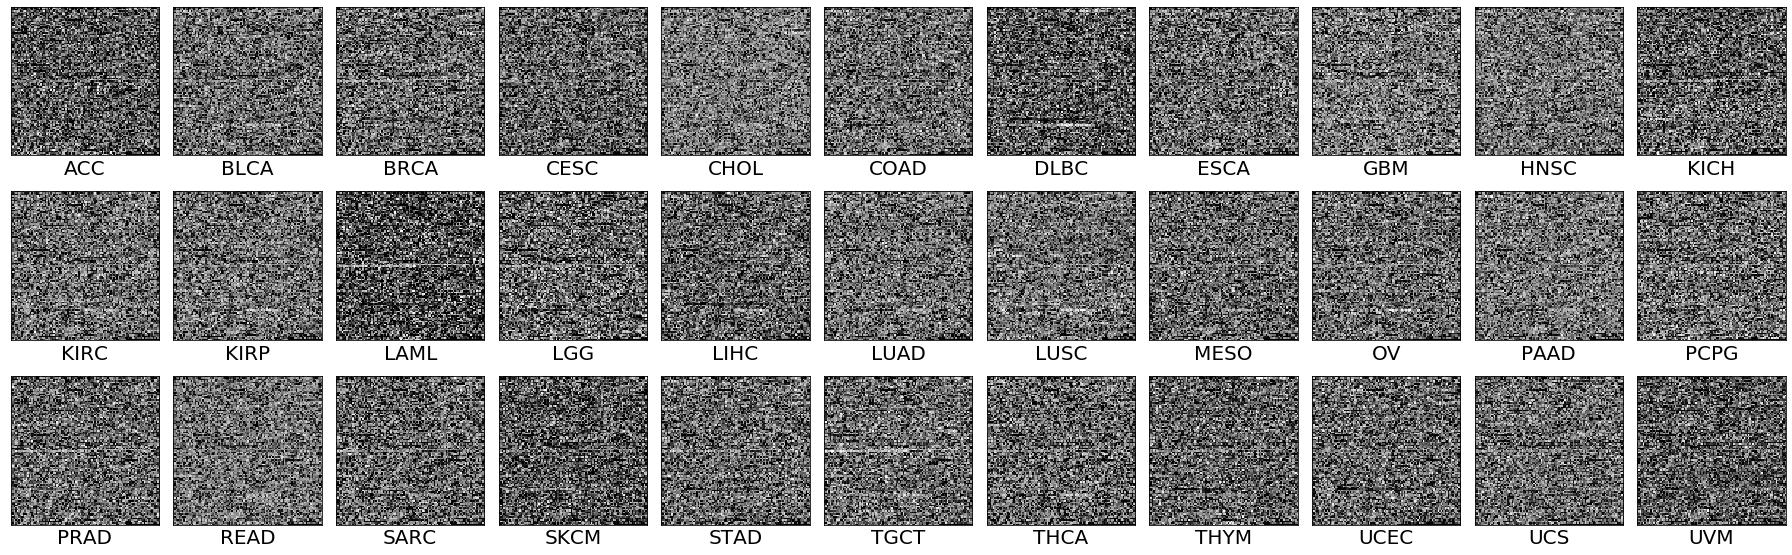

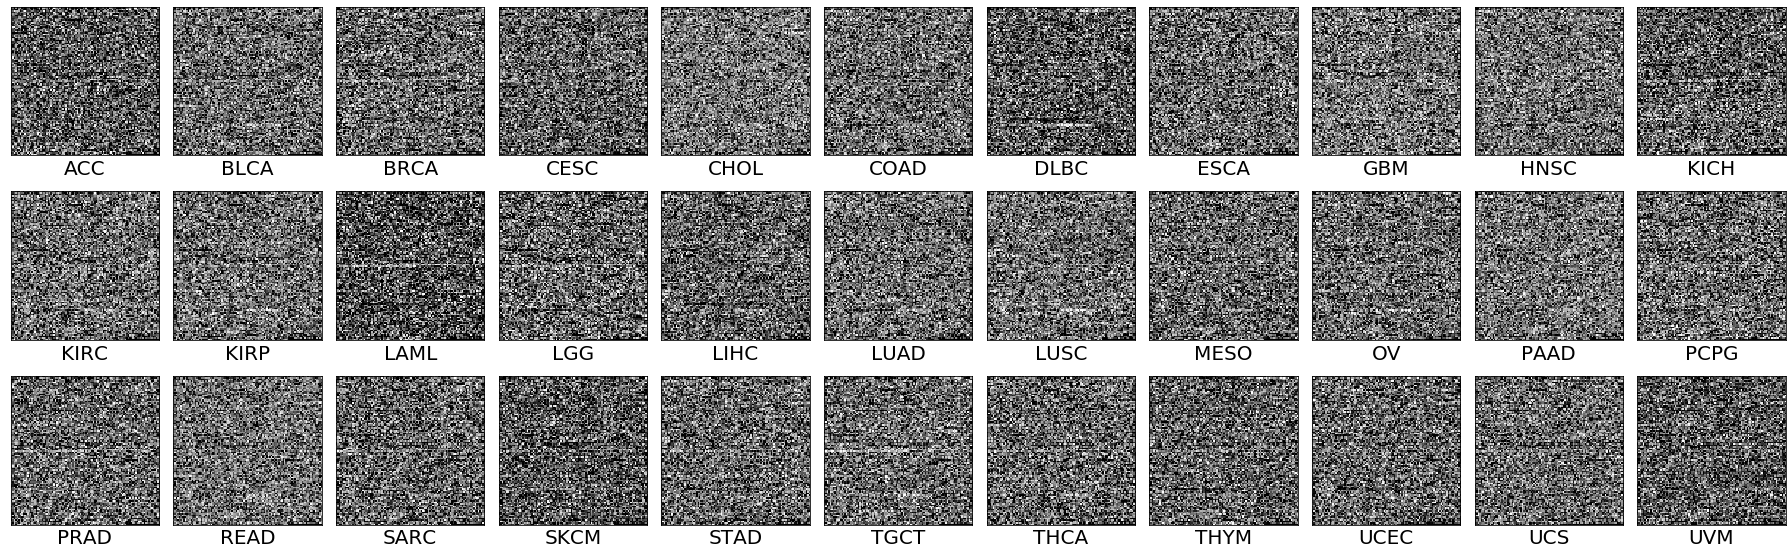

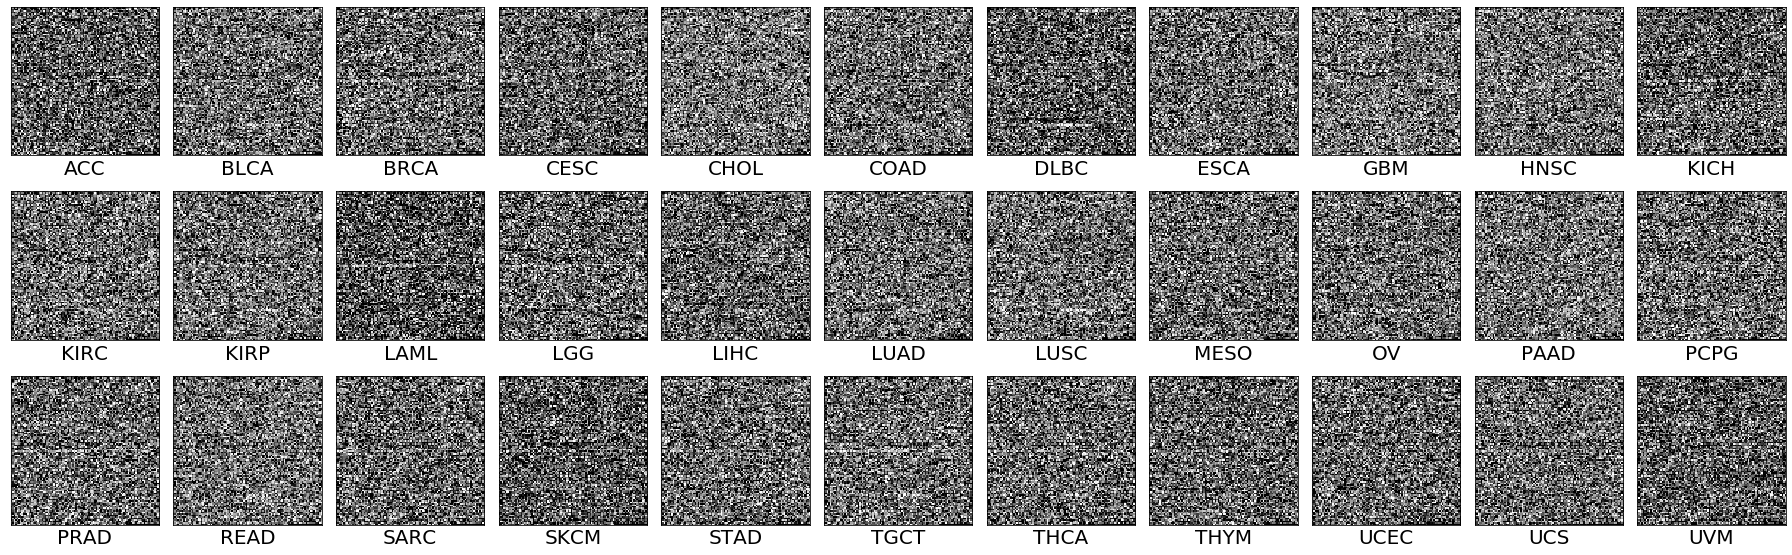

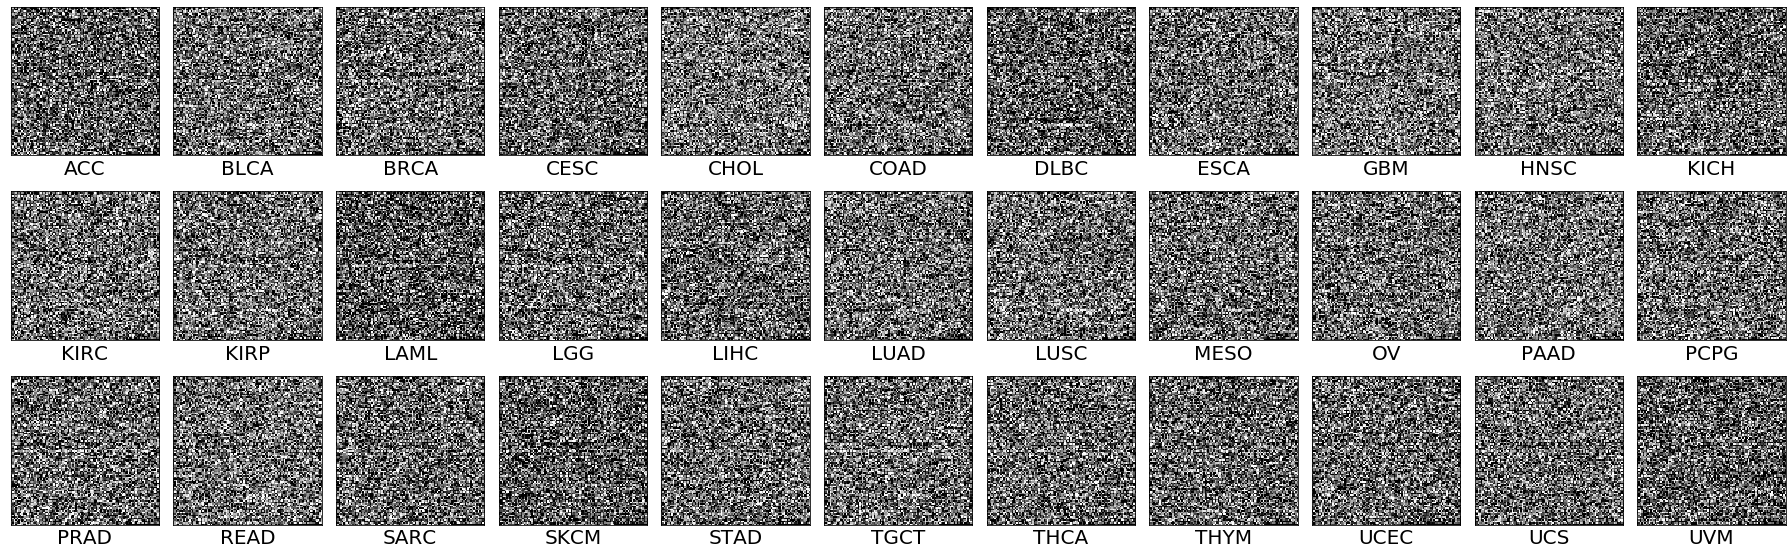

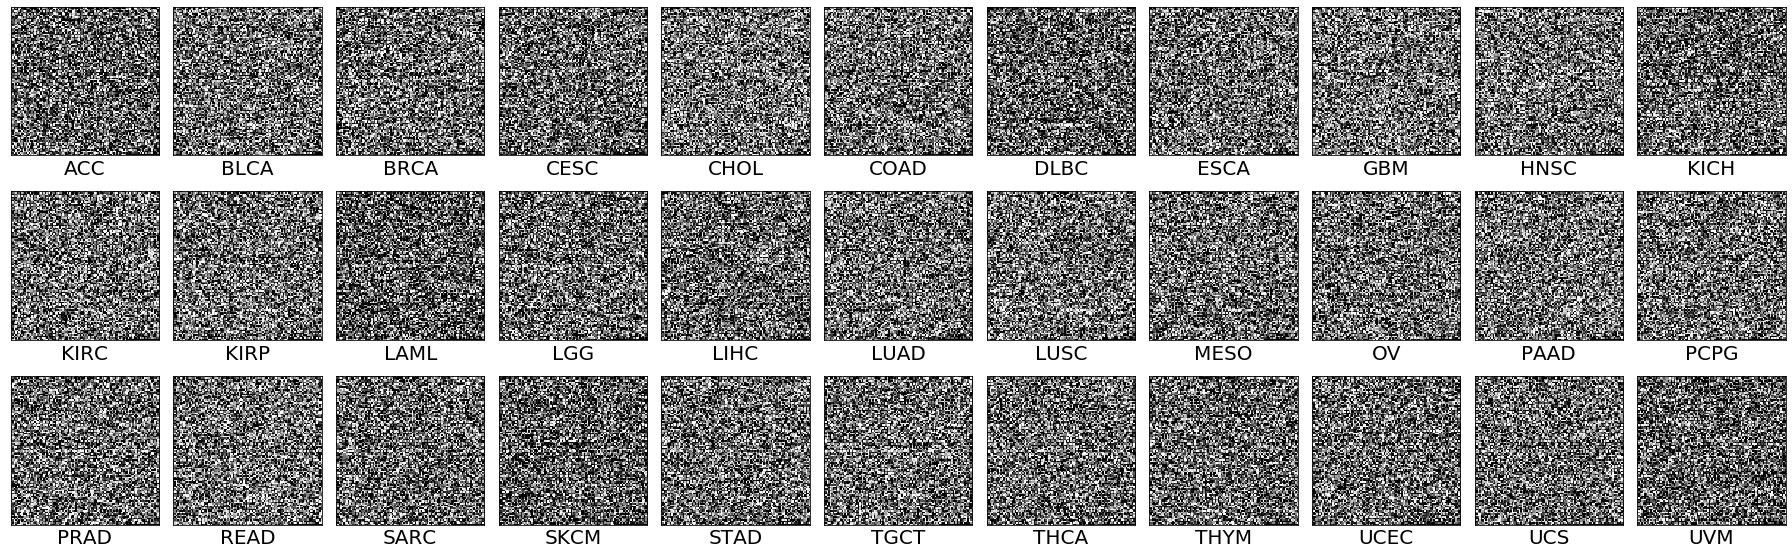

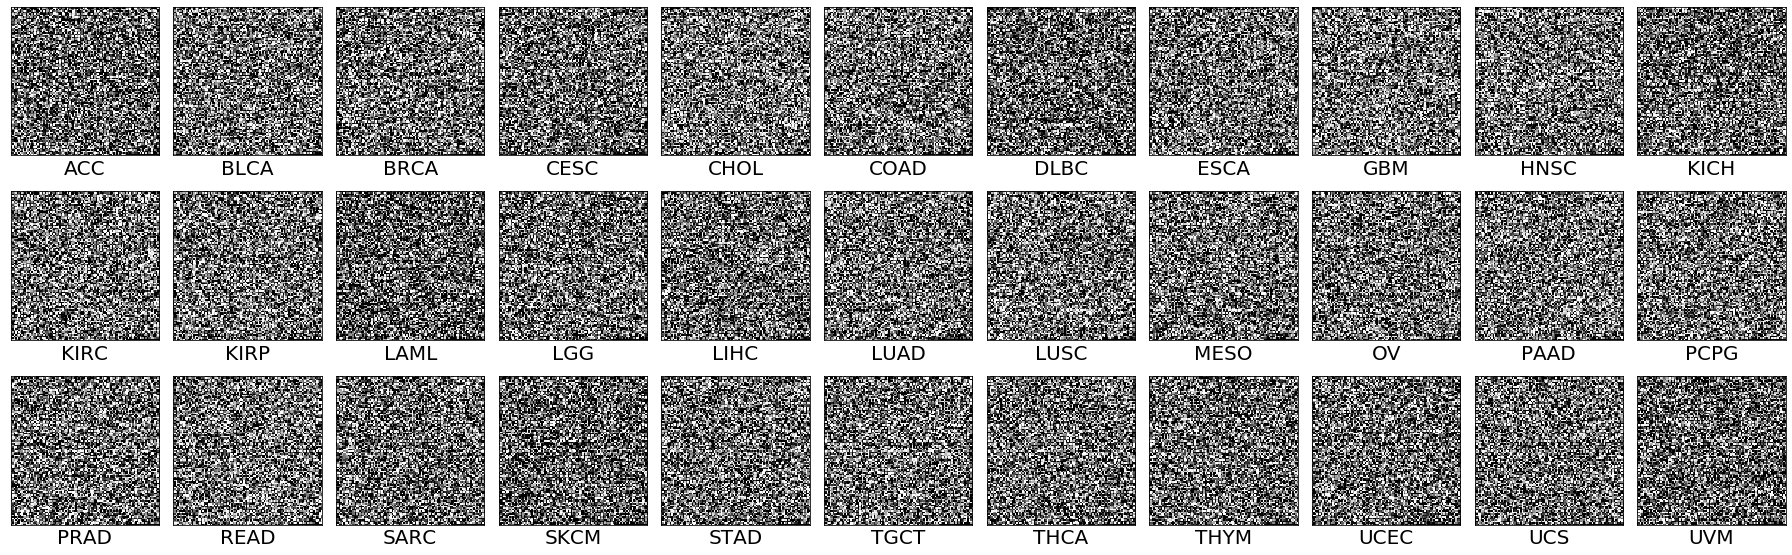

In [93]:
for i, X in enumerate(new_X1_ns):

    idx = dfy.reset_index().groupby('class').apply(lambda x:x.index.tolist())
    rows = idx.index.tolist()
    fontsize = 20
    fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(25, 8), sharex = True, sharey = True)

    for row, ax in zip(rows, axes.ravel()):
        pid = idx.loc[row][0]  
        pid_name = row.split('_')[-1]
        x = X[pid]
        ax.imshow(x.sum(axis=-1), cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        #show.imshow(x.sum(axis=-1).reshape(102,102,1), ax = ax,  mode = 'dark', color_list= ['gray'], x_max=1) #
        ax.set_xlabel(pid_name, fontsize = fontsize) 

    fig.tight_layout()
    fig.savefig('./fmp-%s.png' % i, bbox_inches='tight', dpi=400) 
